
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Lattice Determination with HOLZ

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_12-HOLZ_Example.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_12-HOLZ_Example.ipynb)



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes

## Load relevant python packages
### Check Installed Packages

In [3]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.2.22':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing pyTEMlib
done


## Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all notebook

# additional package 
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

# Import libraries from the book

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

### And we use the image tool library of Quantifit
import pyTEMlib.file_tools as ft
import pyTEMlib
print(pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
0.2021.02.22


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '



## Define  crystal


In [2]:
### Please choose another crystal like: Silicon, Aluminium, GaAs , ZnO
tags = ks.structure_by_name('silicon')


# Plot the unit cell

<IPython.core.display.Javascript object>


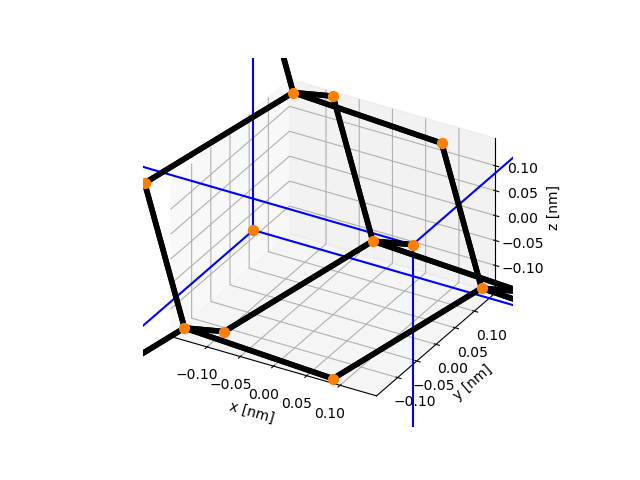

In [3]:
## Just to be sure the crystal structure is right
ks.plot_unitcell(tags)

## Load Diffraction Pattern

<IPython.core.display.Javascript object>


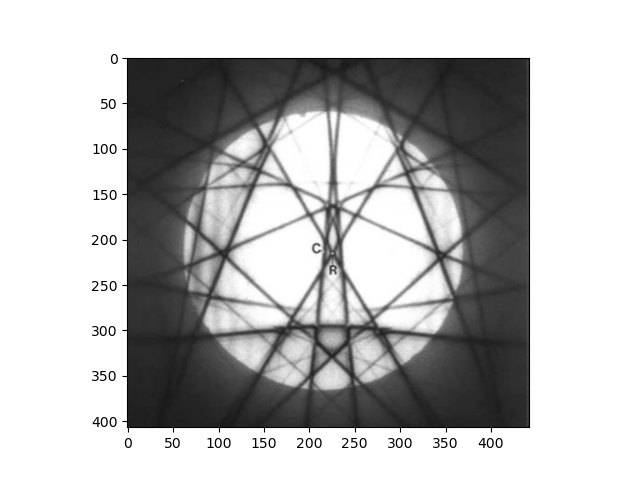

In [4]:
image = plt.imread("images/Zuo-HOLZ-experiment.jpg")
plt.figure()
plt.imshow(image);


# Parameters for Diffraction Calculation

Please note that we are using a rather small number of reflections: the maximum number of hkl is 1

In [5]:

tags['acceleration_voltage_V'] = 98.8*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.0,-0.0,-0.0])  # mistilt in degrees

tags['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['convergence_angle_nm'] = 1.9


## Function for Coverting Hough Coordinates to Line Coordinates

In [6]:

def Hough2Lines(tags):
    angle = np.radians(tags['plot_rotation']) #mrad
    # Calculate nearest point of HOLZ and Kikuchi lines
    
    if 'convergence_angle_nm' in tags:
        L = tags['convergence_angle_nm']*2
    if L < 0.1:
        L=3
    theta = tags['HOLZ']['theta']-angle
    gd_length = tags['HOLZ']['distance'] 
    
    g_closest = np.ones((len(theta),2))
    g_closest[:,1] = np.cos(theta)
    g_closest[:,0] = np.sin(theta)
    
    g_closest =  g_closest*(gd_length/np.linalg.norm(g_closest, axis =1))[:,np.newaxis]
    
    g_line = np.zeros(g_closest.shape)
    g_line[:,0] = np.cos(np.pi-theta)
    g_line[:,1] = np.sin(np.pi-theta)
    

    line_start = g_closest+g_line*L
    line_end = g_closest-g_line*L
    lines = np.zeros((g_line.shape[0],5))
    lines[:,0] = line_start[:,0]
    lines[:,1] = line_end[:,0]
    lines[:,2] = line_start[:,1]
    lines[:,3] = line_end[:,1]
    lines[:,4] = tags['HOLZ']['intensities']#tags['allowed']['intensities']
    
    lines[tags['allowed']['ZOLZ'],4] = tags['allowed']['intensities'][tags['allowed']['ZOLZ']]/tags['allowed']['intensities'].max()*4
    return lines, g_closest


## Initial Overlay

tags['convergence_angle_mrad'] = 0


<IPython.core.display.Javascript object>


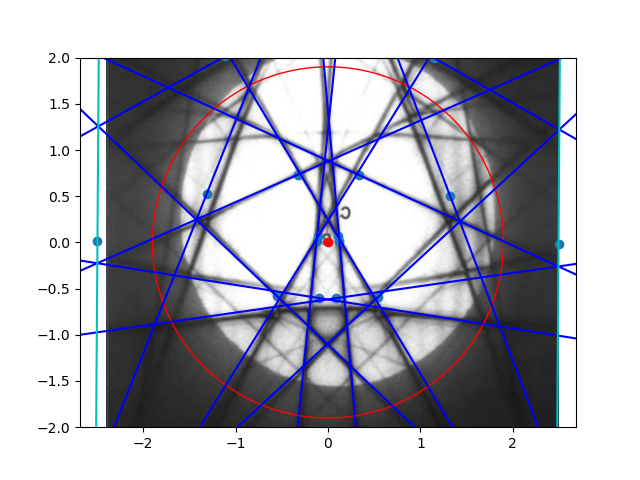

In [7]:
tags['acceleration_voltage_V'] = 98.8*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.0,-0.0,-0.0])  # mistilt in degrees

tags['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['convergence_angle_nm'] = 1.9

ks.kinematic_scattering(tags, False)
alpha = tags['convergence_angle_nm']

# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']
HOLZ = tags['allowed']['HOLZ']
tags['plot_rotation'] = 90-0.4
tags['plot image FOV'] = 4.9
tags['plot shift x'] = 0.05
tags['plot shift y'] = 0.4

l = -tags['plot image FOV']/2.+tags['plot shift x']
r = tags['plot image FOV']/2+tags['plot shift x']
t = -tags['plot image FOV']/2+tags['plot shift y']
b = tags['plot image FOV']/2+tags['plot shift y']
lines, g_closest = Hough2Lines(tags)
g_closest1 = g_closest
plt.figure()#
plt.imshow(image, extent=(r,l,t,b))
plt.scatter(g_closest[:,0],g_closest[:,1])
#plt.scatter(line_start[:,0],line_start[:,1],c='g')
#plt.scatter(line_end[:,0],line_end[:,1],c='g')
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
plt.scatter([0],[0],c='red')

zero_disk = plt.Circle((0, 0), alpha, color='r', fill=False)
plt.gca().add_artist(zero_disk)
plt.axis('equal');
s = 2
plt.gca().set_xlim(-s,s);plt.gca().set_ylim(-s,s);


## Plotting with mistilt included and objective stigmation compensated

<IPython.core.display.Javascript object>


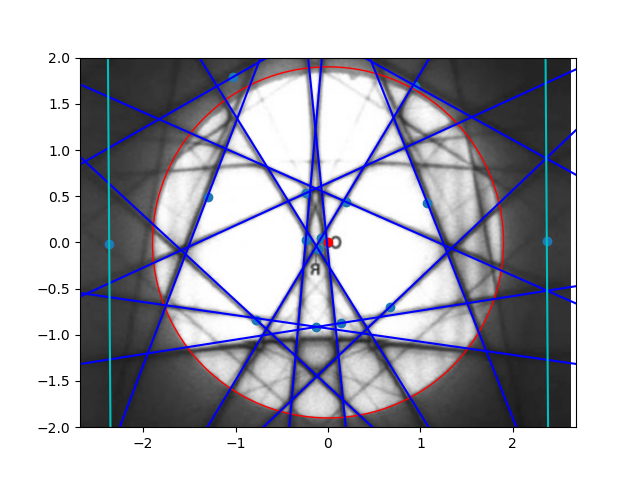

In [8]:
tags['acceleration_voltage_V'] = 98.4*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.05,-0.05,-0.03])  # mistilt in degrees

tags['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['unit_cell'][0,0]=tags['unit_cell'][1,1]*1.00
tags['unit_cell'][2,2]=tags['unit_cell'][1,1]*1.00
tags['unit_cell'][2,1] = .00
tags['unit_cell'] = tags['unit_cell']*1.00

alpha = tags['convergence_angle_nm']
ks.kinematic_scattering(tags, False)

# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']
HOLZ = tags['allowed']['HOLZ']
tags['plot_rotation'] = 90.4
tags['plot image FOV'] = 4.95
tags['plot shift x'] = -.07
tags['plot shift y'] = 0.08
O_stig = 1.09
l = -tags['plot image FOV']*O_stig/2.+tags['plot shift x']
r = tags['plot image FOV']*O_stig/2+tags['plot shift x']
t = -tags['plot image FOV']/2+tags['plot shift y']
b = tags['plot image FOV']/2+tags['plot shift y']
lines, g_closest = Hough2Lines(tags)
plt.figure()
plt.imshow(image, extent=(r,l,t,b))
plt.scatter(g_closest[:,0],g_closest[:,1])
#plt.scatter(line_start[:,0],line_start[:,1],c='g')
#plt.scatter(line_end[:,0],line_end[:,1],c='g')
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
zero_disk = plt.Circle((0, 0), alpha, color='r', fill=False)
plt.scatter([0],[0],c='red')
plt.gca().add_artist(zero_disk)
plt.axis('equal');
s = 2
plt.gca().set_xlim(-s,s);plt.gca().set_ylim(-s,s);

## Plotting more HOLZ lines with intensity

<IPython.core.display.Javascript object>


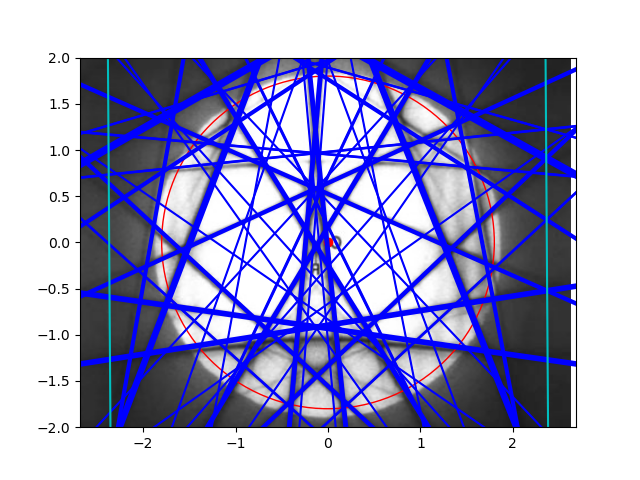

In [9]:

tags['acceleration_voltage_V'] = 98.4*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.05,-0.05,-0.03])  # mistilt in degrees

tags['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 14   # Highest evaluated Miller indices

alpha = 1.8
ks.kinematic_scattering(tags, False)

# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']
HOLZ = tags['allowed']['HOLZ']
tags['plot_rotation'] = 90.4
tags['plot image FOV'] = 4.95
tags['plot shift x'] = -.07
tags['plot shift y'] = 0.08
l = -tags['plot image FOV']*1.09/2.+tags['plot shift x']
r = tags['plot image FOV']*1.09/2+tags['plot shift x']
t = -tags['plot image FOV']/2+tags['plot shift y']
b = tags['plot image FOV']/2+tags['plot shift y']
lines, g_closest = Hough2Lines(tags)

lines  , g_closest = Hough2Lines(tags)
plt.figure()
plt.imshow(image, extent=(r,l,t,b))
for i in range(len(HOLZ)):
    if HOLZ[i]:
        plt.plot((lines[i,0],lines[i,1]),(lines[i,2],lines[i,3]),c='b', linewidth = lines[i,4])
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
zero_disk = plt.Circle((0, 0), alpha, color='r', fill=False)
plt.scatter([0],[0],c='red')
plt.gca().add_artist(zero_disk)
plt.axis('equal');
s = 2.
plt.gca().set_xlim(-s,s);plt.gca().set_ylim(-s,s);


## Save unit cell data

In [10]:
unit_cell = tags['unit_cell'].copy()

## Influence of unit cell deformation

<IPython.core.display.Javascript object>


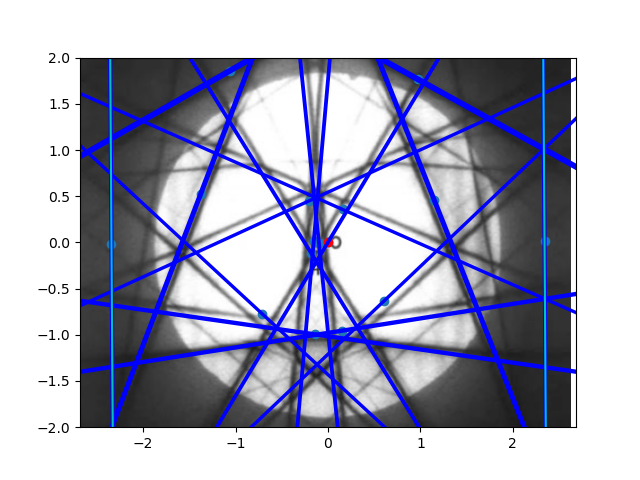

In [11]:
tags['acceleration_voltage_V'] = 98.4*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.05,-0.05,-0.03])  # mistilt in degrees

tags['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['unit_cell'][0,0]=unit_cell[0,0]*1.00
tags['unit_cell'][2,2]=unit_cell[2,2]*1.00
tags['unit_cell'][2,1] = .00

tags['unit_cell'] =unit_cell*1.01

alpha = 1.8
ks.kinematic_scattering(tags, False)

# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']
HOLZ = tags['allowed']['HOLZ']
tags['plot_rotation'] = 90.4
tags['plot image FOV'] = 4.95
tags['plot shift x'] = -.07
tags['plot shift y'] = 0.08
l = -tags['plot image FOV']*1.09/2.+tags['plot shift x']
r = tags['plot image FOV']*1.09/2+tags['plot shift x']
t = -tags['plot image FOV']/2+tags['plot shift y']
b = tags['plot image FOV']/2+tags['plot shift y']
lines, g_closest = Hough2Lines(tags)

lines, g_closest = Hough2Lines(tags)
plt.figure()
plt.imshow(image, extent=(r,l,t,b))
plt.scatter(g_closest[:,0],g_closest[:,1])

#plt.scatter(line_start[:,0],line_start[:,1],c='g')
#plt.scatter(line_end[:,0],line_end[:,1],c='g')
for i in range (lines.shape[0]):
    plt.plot((lines[i,0],lines[i,1]),(lines[i,2],lines[i,3]),c='b',linewidth = lines[i,4]*.75)
#plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b',linewidth = lines[HOLZ,4])
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
plt.scatter([0],[0],c='red')
zero_disk = plt.Circle((0, 0), alpha, color='r', fill=False)
#plt.gca().add_artist(zero_disk)
plt.axis('equal');
s = 2
plt.gca().set_xlim(-s,s);plt.gca().set_ylim(-s,s);


## Navigation

- <font size = "3">  **Back: [HOLZ Lines](CH2_11-HOLZ_Lines.ipynb)** </font>
- <font size = "3">  **Next: [Kinematic Diffraction with KinsCat](CH2_13-Kinematic_Diffraction_with_KinsCat.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
